# IV Rank Based Short Straddle Strategy

In the IV Rank calculation notebook, we discussed how to interpret and use the IV rank. To deploy a short straddle, we look for a high IV rank, which indicates higher volatility. In this notebook, we will backtest the short straddle strategy and analyse the trades.

The notebook is structured as follows:
1. [Read the Data](#read)
2. [Calculate the ATM Strike](#atm)
3. [Strategy Parameters](#parameters)
4. [Entry Condition](#entry)
5. [Exit Conditions](#exit)
6. [Backtesting](#backtesting)
7. [Trade Level Analytics](#trade_level_analytics)

## Import Libraries

In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# Import trade level analytics function
import sys
sys.path.append("..")
from data_modules.adv_options_volatility_utils import trade_level_analytics

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

C:\Users\HP\AppData\Local\Temp\ipykernel_20612\1798231989.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<a id='read'></a>
## Read the Data

Read the files `spx_eom_expiry_options_2015_2023.bz2`, `IV_Rank_spx_2016_2023.csv` (IV rank data). We have calculated and saved the IV rank data in the `IV Rank Calculation` notebook. These files are available in the zip file.

In [2]:
# Read the data
options_data = pd.read_pickle('C:/Users/HP/Documents/Options_vol_trading/AdvancedOptionsVolatilityTradingStrategiesResources/Advanced_Options_Volatility/data_modules/spx_eom_expiry_options_2015_2023.bz2')
IV_rank = pd.read_csv('C:/Users/HP/Documents/Options_vol_trading/AdvancedOptionsVolatilityTradingStrategiesResources/Advanced_Options_Volatility/data_modules/IV_Rank_spx_2016_2023.csv', index_col=0)

# Change the index type to datetime
IV_rank.index = pd.to_datetime(IV_rank.index)

# Removing columns not needed for this strategy
options_data = options_data.drop(columns=[' [STRIKE_DISTANCE_PCT]', ' [C_IV]', ' [P_IV]',
                                          ' [C_GAMMA]', ' [C_VEGA]', ' [C_THETA]',
                                          ' [P_GAMMA]', ' [P_VEGA]', ' [P_THETA]', ' [C_VOLUME]',
                                          ' [P_VOLUME]'])

# Join IV_rank to options_data on its index
options_data = options_data.join(IV_rank, on=options_data.index)

# Drop rows with any missing values
options_data.dropna(inplace=True)

# Display the last 5 rows of the dataframe
options_data.tail()

,[STRIKE],[C_LAST],[UNDERLYING_LAST],[P_LAST],[EXPIRE_DATE],[DTE],[C_DELTA],[P_DELTA],IV_Rank
[QUOTE_DATE],,,,,,,,,
2023-12-28,3905.0,678.42,4783.83,0.10,2023-12-29,1.0,0.99052,-0.00040,31.37
2023-12-28,3900.0,500.87,4783.83,0.05,2023-12-29,1.0,0.99088,-0.00040,31.37
2023-12-28,3895.0,0.00,4783.83,0.05,2023-12-29,1.0,0.99136,0.00000,31.37
2023-12-28,3945.0,584.74,4783.83,0.15,2023-12-29,1.0,0.99113,-0.00019,31.37
2023-12-28,3770.0,0.00,4783.83,0.20,2023-12-29,1.0,0.99287,0.00000,31.37


<a id='atm'></a>
## Calculate the ATM Strike

We will follow the same process to calculate the ATM strike price that we have followed previously.

In [3]:
# Set the strike multiple
# This determines the interval at which strike prices are rounded
# We have discussed the logic for this in detail in the previous notebooks
strike_multiple = 5

# Determine the ATM strike price
# Calculate the ATM strike price by rounding the last traded price of the underlying asset
# to the nearest multiple of the strike_multiple.
options_data['ATM'] = strike_multiple * \
    (round(options_data[' [UNDERLYING_LAST]'] / strike_multiple))

# Display the last 5 rows of the dataframe
options_data.tail()

,[STRIKE],[C_LAST],[UNDERLYING_LAST],[P_LAST],[EXPIRE_DATE],[DTE],[C_DELTA],[P_DELTA],IV_Rank,ATM
[QUOTE_DATE],,,,,,,,,,
2023-12-28,3905.0,678.42,4783.83,0.10,2023-12-29,1.0,0.99052,-0.00040,31.37,4785.0
2023-12-28,3900.0,500.87,4783.83,0.05,2023-12-29,1.0,0.99088,-0.00040,31.37,4785.0
2023-12-28,3895.0,0.00,4783.83,0.05,2023-12-29,1.0,0.99136,0.00000,31.37,4785.0
2023-12-28,3945.0,584.74,4783.83,0.15,2023-12-29,1.0,0.99113,-0.00019,31.37,4785.0
2023-12-28,3770.0,0.00,4783.83,0.20,2023-12-29,1.0,0.99287,0.00000,31.37,4785.0


<a id='parameters'></a>
## Strategy Parameters

We have a parameter `days_to_exit_before_expiry` which we have kept as `3` as we don't want to hold it till expiry to avoid huge MTM swing when expiry is near. You can change this as per your strategy.

In [4]:
config = {
    'days_to_exit_before_expiry': 3
}

<a id='entry'></a>
## Entry Condition

We will check the following condition for entry:
1. IV rank should be greater than or equal to 50.

Create a column `Signal` which stores `1` when the above condition is met.

In [5]:
# Check whether IV Rank is greater than or equal to 50 
options_data['Signal'] = np.where(options_data['IV_Rank'] >= 50 , 1, np.NaN)

<a id='exit'></a>
## Exit Conditions

We will check for any of the following two conditions for exit:

1. The days to expiry stored in the `DTE` column of the `options_data` dataframe is less or equal to the `days_to_exit_before_expiry`. For all such days we will store `0` in the `Signal` column as we do not want to take any new position between this.
2. The IV rank is less than `30`.

The `Signal` column stores `0` when any of the above two conditions are met.

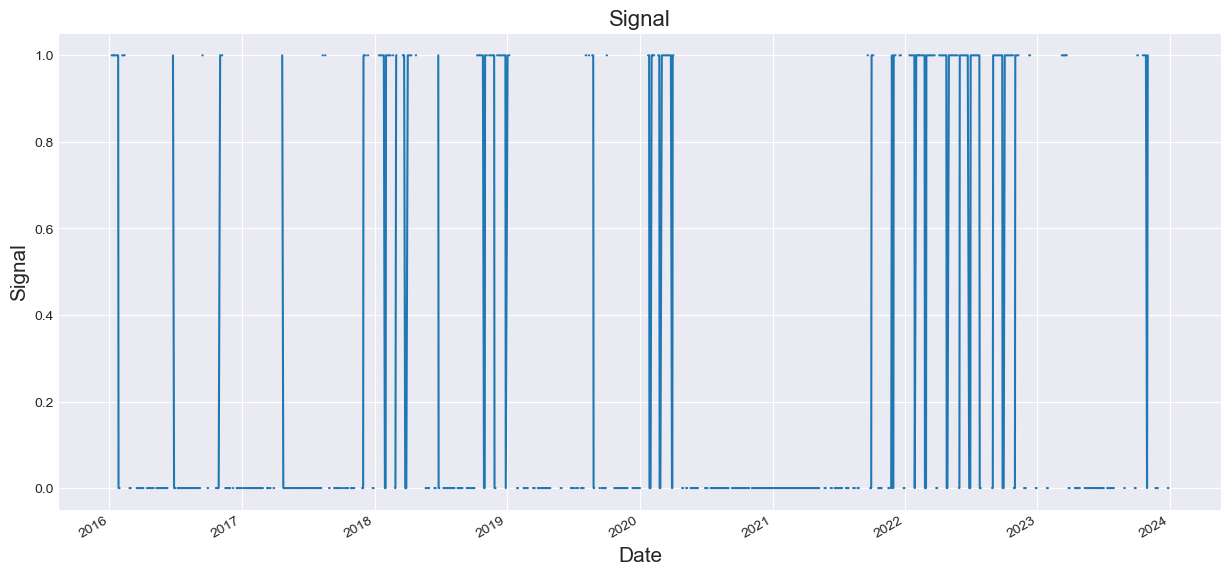

In [6]:
# Initialise the Exit_Type column
options_data['Exit_Type'] = np.NaN

# If DTE is less than or equal to days to exit before expiry then we exit the do not take an entry
options_data['Signal'] = np.where(options_data[' [DTE]'] <= config['days_to_exit_before_expiry'] , 0, options_data['Signal'])
options_data['Exit_Type'] = np.where(options_data[' [DTE]'] <= config['days_to_exit_before_expiry'], 'Expiry Exit', options_data['Exit_Type'])

# Set 'Signal' to 0 if the IV rank is less than 30
options_data['Signal'] = np.where((options_data['IV_Rank'] < 30), 0, options_data['Signal'])
options_data['Exit_Type'] = np.where((options_data['IV_Rank'] < 30), 'IV Rank Exit', options_data['Exit_Type'])

# Plot the signal
plt.figure(figsize=(15, 7))
options_data['Signal'].plot()
plt.title('Signal', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.show()

In [8]:
options_data.Signal.value_counts()

0.0    226270
1.0    115258
Name: Signal, dtype: int64

<a id='backtesting'></a>
## Backtesting

You will loop over each of the dates in the data, set up the straddle when entry condition is met, exit when exit conditions are met, and update the trade in `round_trips_details`.

`mark_to_market` dataframe contains the premiums of the strategy on each date between the entry date and exit date.

You will backtest the straddle using the following steps:

**Step-1**: Create dataframes `round_trips_details`, `trades` and `mark_to_market` for storing round trips, trades, and mtm, respectively.

**Step-2**: Define a function `add_to_mtm` which stores daily mark_to_market values for the strategy. It takes the existing `mark_to_market` dataframe, `option_strategy` which is a straddle in this case and `trading_date` as inputs.

**Step-3**: Define a function `get_premium` to get the premium for the two legs(CE and PE) of the straddle. It takes `options_strategy` and `options_data` as inputs.

**Step-4**: Define a function `setup_straddle` to set up the straddle strategy. It takes `options_data` and `direction` (long/short) as inputs.

**Step-5**: Initialise `current_position`, `trade_num`, which is basically the number of trades, `cum_pnl` to 0 and set the `entry_flag` to `False`. 

**Step-6**: You also set the `start_date` for backtesting.

In [9]:
# Create dataframes for round trips, storing trades, and mtm
round_trips_details = pd.DataFrame()
trades = pd.DataFrame()
mark_to_market = pd.DataFrame()

# Function for calculating mtm
def add_to_mtm(mark_to_market, option_strategy, trading_date):
    option_strategy['Date'] = trading_date
    mark_to_market = pd.concat([mark_to_market, option_strategy])
    return mark_to_market

# Function for fetching premium
def get_premium(options_strategy, options_data):

    # Get the premium for call option
    if options_strategy['Option Type'] == "CE":
        return options_data[' [C_LAST]']

    # Get the premium for put option
    elif options_strategy['Option Type'] == "PE":
        return options_data[' [P_LAST]']
    
# Function for fetching delta
def get_delta(options_strategy, options_data):
    
    # Get the delta for call option
    if options_strategy['Option Type'] == "CE":
        return options_data[' [C_DELTA]']

    # Get the delta for put option
    elif options_strategy['Option Type'] == "PE":
        return options_data[' [P_DELTA]']

# Function for setting up a straddle
def setup_straddle(options_data, direction='short'):

    # Create a dataframe to store the straddle
    straddle = pd.DataFrame()

    # CE and PE legs of the straddle
    straddle['Option Type'] = ['CE', 'PE']

    # Create the straddle at ATM
    straddle['Strike Price'] = options_data.ATM[0]

    # Sell positions for both CE and PE legs in case of a short straddle
    straddle['Position'] = -1
    
    # Buy positions for both CE and PE legs in case of a long straddle
    if direction == 'long':
        straddle['Position'] = 1
        
    # Get the premiums for the two option legs of the straddle
    straddle['Premium'] = straddle.apply(lambda r: get_premium(r, options_data), axis=1)

    # Get the delta values for the two option legs of the straddle
    straddle['Delta'] = straddle.apply(lambda r: get_delta(r, options_data), axis=1)

    return straddle

# Initialise current position, number of trades and cumulative pnl to 0
current_position = 0
trade_num = 0
cum_pnl = 0

# Set exit flag to False
exit_flag = False

# Set start date for backtesting
start_date = options_data.index[0]

**Note:** We have saved the functions `add_to_mtm`, `get_premium`, `get_delta` and `setup_straddle` in the `adv_options_volatility_utils.py` file in the data_modules folder of the zip file. We will directly import these functions in the upcoming notebooks.

**Step-7**: You will check if there is an open position first. If there is an open position, you exit the trade if any of the exit condition is met, and update round trips. You will calculate the pnl for each trade and also the update the cumulative pnl.

**Step-8**: For a given date, if there is no open position, entry condition is met, you will set up the straddle.

In [10]:
# Iterate through unique dates starting from 'start_date'
for i in options_data.loc[start_date:].index.unique():
    
    # Retrieve options data for the current date
    today_data = options_data.loc[i]

    # Check if a position is currently active
    if current_position == 1:
        
        # Filter data for the specific strike price of the straddle
        setup_strike_data = today_data[today_data[' [STRIKE]'] == setup_strike]
        
        # Update the premium values for the straddle
        straddle['Premium'] = straddle.apply(lambda r: get_premium(r, setup_strike_data), axis=1)
        
        # Calculate the net premium by summing the position * premium for each leg
        net_premium = (straddle.Position * straddle.Premium).sum()
        
        # Update delta values for the straddle
        # We will use the delta values in the course later after a detailed discussion on delta
        straddle['Delta'] = straddle.apply(lambda r: get_delta(r, setup_strike_data), axis=1)
        
        # Add the current straddle data to the mark-to-market dataframe
        mark_to_market = add_to_mtm(mark_to_market, straddle, i)
        
        # Check if any exit conditions are met
        if today_data['Signal'][0] == 0:
            exit_type = today_data['Exit_Type'][0]                
            exit_flag = True 
        
        # If an exit condition is met, process the exit
        if exit_flag:
            # Record exit date, type, and premium
            trades['Exit_Date'] = i
            trades['Exit_Type'] = exit_type
            trades['Exit_Price'] = straddle.Premium

            # Calculate the net premium at exit
            net_premium = round((straddle.Position * straddle.Premium).sum(), 1)

            # Calculate the net premium on entry
            entry_net_premium = (trades.Position * trades.Entry_Price).sum()

            # Calculate PnL for the trade
            trade_pnl = round(net_premium - entry_net_premium, 1)
            trades['PnL'] = (trades['Entry_Price'] - trades['Exit_Price'])

            # Add the completed trade to the round trip details
            round_trips_details = pd.concat([round_trips_details, trades])

            # Update the cumulative PnL
            cum_pnl += trade_pnl
            cum_pnl = round(cum_pnl, 2)

            # Print details of the completed trade
            print(f"Trade No: {trade_num} | Exit Type: {exit_type} | Date: {i} | Premium: {net_premium} | Trade PnL: {trade_pnl} | Cum PnL: {cum_pnl}")

            # Reset the position status
            current_position = 0

            # Reset the exit flag
            exit_flag = False
        
    # Check if no position is currently active and a new signal is triggered
    if current_position == 0 and today_data['Signal'][0] == 1:
        
        # Filter data for the ATM (at-the-money) strike price
        setup_strike_data = today_data[today_data['ATM'] == today_data[' [STRIKE]']]
        
        # Setup the new straddle with the ATM strike
        straddle = setup_straddle(setup_strike_data, direction="short")
        
        # Store the strike price for the new straddle
        setup_strike = today_data['ATM'][0]

        # Record the entry details for the trade
        trades = straddle.copy()
        trades['Entry_Date'] = i
        trades.rename(columns={'Premium': 'Entry_Price'}, inplace=True)

        # Calculate the net premium at entry
        net_premium = round((straddle.Position * straddle.Premium).sum(), 1)

        # Update the position status to active
        current_position = 1

        # Add the new straddle to the mark-to-market dataframe
        mark_to_market = add_to_mtm(mark_to_market, straddle, i)

        # Increment the trade count
        trade_num += 1
        
        # Print details of the new trade entry
        print("-" * 30)
        print(f"Trade No: {trade_num} | Entry | Date: {i} | Premium: {net_premium} | Trade PnL: 0 | Cum PnL: {cum_pnl}")

------------------------------
Trade No: 1 | Entry | Date: 2016-01-07 00:00:00 | Premium: -82.7 | Trade PnL: 0 | Cum PnL: 0
Trade No: 1 | Exit Type: Expiry Exit | Date: 2016-01-26 00:00:00 | Premium: -52.8 | Trade PnL: 29.9 | Cum PnL: 29.9
------------------------------
Trade No: 2 | Entry | Date: 2016-02-05 00:00:00 | Premium: -81.4 | Trade PnL: 0 | Cum PnL: 29.9
Trade No: 2 | Exit Type: IV Rank Exit | Date: 2016-02-25 00:00:00 | Premium: -52.2 | Trade PnL: 29.1 | Cum PnL: 59.0
------------------------------
Trade No: 3 | Entry | Date: 2016-06-22 00:00:00 | Premium: -61.2 | Trade PnL: 0 | Cum PnL: 59.0
Trade No: 3 | Exit Type: Expiry Exit | Date: 2016-06-27 00:00:00 | Premium: -86.5 | Trade PnL: -25.2 | Cum PnL: 33.8
------------------------------
Trade No: 4 | Entry | Date: 2016-09-13 00:00:00 | Premium: -62.4 | Trade PnL: 0 | Cum PnL: 33.8
Trade No: 4 | Exit Type: IV Rank Exit | Date: 2016-09-22 00:00:00 | Premium: -56.5 | Trade PnL: 5.9 | Cum PnL: 39.7
-----------------------------

Trade No: 34 | Exit Type: Expiry Exit | Date: 2022-06-27 00:00:00 | Premium: -197.4 | Trade PnL: 12.9 | Cum PnL: -16.7
------------------------------
Trade No: 35 | Entry | Date: 2022-07-01 00:00:00 | Premium: -212.2 | Trade PnL: 0 | Cum PnL: -16.7
Trade No: 35 | Exit Type: Expiry Exit | Date: 2022-07-26 00:00:00 | Premium: -165.7 | Trade PnL: 46.5 | Cum PnL: 29.8
------------------------------
Trade No: 36 | Entry | Date: 2022-08-02 00:00:00 | Premium: -207.7 | Trade PnL: 0 | Cum PnL: 29.8
Trade No: 36 | Exit Type: Expiry Exit | Date: 2022-08-29 00:00:00 | Premium: -70.5 | Trade PnL: 137.2 | Cum PnL: 167.0
------------------------------
Trade No: 37 | Entry | Date: 2022-09-01 00:00:00 | Premium: -223.3 | Trade PnL: 0 | Cum PnL: 167.0
Trade No: 37 | Exit Type: Expiry Exit | Date: 2022-09-27 00:00:00 | Premium: -289.6 | Trade PnL: -66.3 | Cum PnL: 100.7
------------------------------
Trade No: 38 | Entry | Date: 2022-10-03 00:00:00 | Premium: -216.1 | Trade PnL: 0 | Cum PnL: 100.7
Trade

Let's print the round trip and mark-to-market details.

In [11]:
# Round trip details
round_trips_details.tail()

,Option Type,Strike Price,Position,Entry_Price,Delta,Entry_Date,Exit_Date,Exit_Type,Exit_Price,PnL
1,PE,3920.0,-1,81.45,-0.50490,2023-03-09,2023-03-28,Expiry Exit,11.19,70.26
0,CE,4230.0,-1,123.40,0.53695,2023-10-03,2023-10-30,Expiry Exit,0.75,122.65
1,PE,4230.0,-1,79.67,-0.46798,2023-10-03,2023-10-30,Expiry Exit,59.76,19.91
0,CE,4240.0,-1,57.10,0.53573,2023-11-01,2023-11-22,IV Rank Exit,163.16,-106.06
1,PE,4240.0,-1,93.12,-0.47108,2023-11-01,2023-11-22,IV Rank Exit,1.10,92.02


In [12]:
# MTM details
mark_to_market.tail()

,Option Type,Strike Price,Position,Premium,Delta,Date
1,PE,4240.0,-1,1.10,-0.01476,2023-11-20
0,CE,4240.0,-1,163.16,0.96439,2023-11-21
1,PE,4240.0,-1,1.10,-0.01370,2023-11-21
0,CE,4240.0,-1,163.16,0.94614,2023-11-22
1,PE,4240.0,-1,1.10,-0.00913,2023-11-22


<a id='trade_level_analytics'></a>
## Trade Level Analytics

Use the `trade_level_analytics` function to generate the trade level analytics of the trade. It takes the `round_trips` dataframe and `lot_size` as the input. <br>

The following are the output of the `trade_level_analytics` function. 
* Total PnL	
* Total Trades
* Number of Winners
* Number of Losers
* Win (%)
* Loss (%)
* Per Trade PnL of Winners
* Per Trade PnL of Losers
* Profit Factor

You can find the function in the `adv_options_volatility_utils.py` file in the zip file.

In [13]:
# Trade Level Analytics
# Assume lot size as 5
analytics = trade_level_analytics(round_trips_details, lot_size= 5)
analytics

,Strategy
Total PnL,3262.50
Total Trades,43.00
Number of Winners,29.00
Number of Losers,14.00
Win (%),67.44
Loss (%),32.56
Per Trade PnL of Winners,277.42
Per Trade PnL of Losers,341.63
Profit Factor,1.68


The short straddle trading strategy has a win rate of `67.44%` and the profit factor of `1.68`. This indicates that the strategy has been profitable, with profits outweighing losses by some margin. But `Per Trade PnL of Losers` is `341` which is quite high. This means that we are losing `$341` on every losing trade.

<a id='conclusion'></a>
## Conclusion

In this notebook, we backtested a short straddle strategy, taking entry positions based on IV rank. While analysing the trades we saw that we are losing heavily when our trade goes wrong. <br><br>